## Person Identification from Image
### Bret Young
### 29 January 21

In [1]:
# load required packages

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from keras.applications import VGG19 as PTM
from keras.applications import VGG16 as PreTrained
from keras.applications.vgg19 import  preprocess_input
from keras.applications.vgg16 import  preprocess_input
from tensorflow.keras import backend as bk
import numpy as np
from tqdm.notebook import tqdm
import glob
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
%matplotlib inline

In [2]:
# Base file path

train_path = '~/Documents/GitHub/Facial_Identification/face_id_data/train'
val_path = '~/Documents/GitHub/Facial_Identification/face_id_data/val'

# File name pattern matching

glob_train = glob.glob("{}/*/*".format(train_path))
glob_test  = glob.glob("{}/*/*".format(val_path))

In [3]:
def get_class_name(path):
      class_name = os.path.basename(os.path.dirname(os.path.normpath(path)))
      return class_name

In [4]:
# Read training images and add to list with status bar

target_size = (224,224)

training_data  = []
training_lable = []

print("Loading Training Data...")
for train_path in tqdm(glob_train):
    img = image.load_img(train_path, color_mode = 'rgb', target_size = target_size)
    img = image.img_to_array(img)
    class_name_train = get_class_name(train_path)
    training_data.append(img)
    training_lable.append(class_name_train)
print("Training Data Loaded.")

Loading Training Data...


  0%|          | 0/93 [00:00<?, ?it/s]

Training Data Loaded.


In [5]:
# Read validation images and add to list with status bar

val_data = []
val_lable = []

print("Loading Validation Data...")
for val_path in tqdm(glob_test):
    img = image.load_img(val_path, color_mode = 'rgb', target_size = target_size)
    img = image.img_to_array(img)
    class_name_val = get_class_name(val_path)
    val_data.append(img)
    val_lable.append(class_name_val)
print("Validation Data Loaded.")

Loading Validation Data...


  0%|          | 0/25 [00:00<?, ?it/s]

Validation Data Loaded.


In [6]:
# Get class labels from training data

encoder = LabelEncoder()
training_lable_cat = to_categorical(encoder.fit_transform(training_lable))
val_lable_cat = to_categorical(encoder.transform(val_lable))
classes = encoder.classes_
classes = list(classes)
print(classes)

['ben_afflek', 'elton_john', 'jerry_seinfeld', 'madonna', 'mindy_kaling']


In [7]:
# Apply augmentation to training photos

augmented = []

datagen = ImageDataGenerator(rotation_range = 30,
                             zoom_range = 0.15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.15,
                             horizontal_flip = True, 
                             fill_mode = "nearest")

print("Initiating Image Augmentation....")
for training_image in tqdm(training_data):
    img_expand = np.expand_dims(training_image, axis = 0)
    aug_data = datagen.flow(img_expand, batch_size = 1)
    augmented.append(aug_data)
print("Image Augmentation Complete.")

Initiating Image Augmentation....


  0%|          | 0/93 [00:00<?, ?it/s]

Image Augmentation Complete.


In [8]:
# Expand size of training data with augmented photos

training_data_augmented = []
training_data_lable_cat = []

print("Generating Data...")
for i in tqdm(range(len(augmented))):
    lable = training_lable_cat[i]
    img_aug_data = augmented[i]
    for i in range(25):
        batch = img_aug_data.next()
        image = batch[0].astype('uint8')
        image = np.array(image)
        training_data_augmented.append(image)
        training_data_lable_cat.append(lable)
print("Generating Data Complete.")

Generating Data...


  0%|          | 0/93 [00:00<?, ?it/s]

Generating Data Complete.


In [9]:
# load keras VGG19 weights

ptm = PTM(weights = 'imagenet',
         include_top = False,
         pooling = 'avg')

# set parameters to non-trainable
ptm.trainable = False

In [10]:
# Extract features from training data

training_features = []

print("Extracting Training Features ...")
for image in tqdm(training_data_augmented):
    img = np.expand_dims(image, axis = 0)
    training_feature = ptm.predict(preprocess_input(img))[0]
    training_features.append(training_feature)
print("Extracting Training Features Complete.")

Extracting Training Features ...


  0%|          | 0/2325 [00:00<?, ?it/s]

Extracting Training Features Complete.


In [11]:
# Create dataframe of extracted training features

training_features_df = pd.DataFrame(training_features)

In [12]:
# Split data into training and test set

x_train, x_test, y_train, y_test = train_test_split(training_features_df.values,
                                                    np.asarray(training_data_lable_cat),
                                                    test_size = 0.25,
                                                    random_state = 42)

In [13]:
# Create model

model = Sequential()

model.add(Dense(1024, activation = 'relu', input_shape = (512, )))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation = 'relu', input_shape = (512, )))
model.add(Dense(5, activation = 'softmax'))

In [14]:
# Compile the model

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [15]:
# Fit model to training data and validate with test data

history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    batch_size = 5,
                    validation_data = (x_test, y_test))

Epoch 1/10
349/349 [==============================] - 2s 6ms/step - loss: 0.4409 - accuracy: 0.8526 - val_loss: 0.0368 - val_accuracy: 0.9880
Epoch 2/10
349/349 [==============================] - 2s 5ms/step - loss: 0.2051 - accuracy: 0.9225 - val_loss: 0.0127 - val_accuracy: 0.9966
Epoch 3/10
349/349 [==============================] - 2s 5ms/step - loss: 0.1889 - accuracy: 0.9421 - val_loss: 0.0548 - val_accuracy: 0.9794
Epoch 4/10
349/349 [==============================] - 2s 5ms/step - loss: 0.1150 - accuracy: 0.9621 - val_loss: 0.0054 - val_accuracy: 0.9983
Epoch 5/10
349/349 [==============================] - 2s 6ms/step - loss: 0.1072 - accuracy: 0.9684 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 6/10
349/349 [==============================] - 2s 6ms/step - loss: 0.0937 - accuracy: 0.9690 - val_loss: 0.0152 - val_accuracy: 0.9914
Epoch 7/10
349/349 [==============================] - 2s 6ms/step - loss: 0.1125 - accuracy: 0.9627 - val_loss: 0.0105 - val_accuracy: 0.9966
Epoch 

In [16]:
# Evaluate the model on test data

test_loss, test_acc = model.evaluate(x_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 1.0000


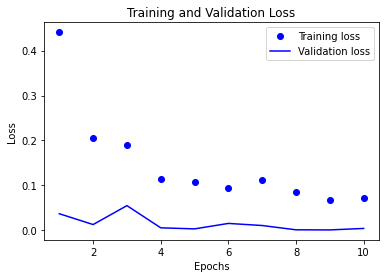

In [17]:
# visualizing training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

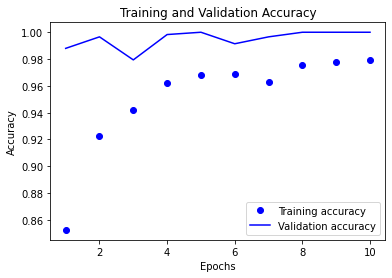

In [18]:
# visualizing training and validation accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
# use model to make predictions

predicts = model.predict(x_test)

In [20]:
# Extract features from validation data

valadition_set_attr = []

print("Extracting Testing Features...")
for val_image in tqdm(val_data):
    val_img = np.expand_dims(val_image, axis = 0)
    val_attr = ptm.predict(preprocess_input(val_img))[0]
    valadition_set_attr.append(val_attr)
print("Extracting Testing Features Complete.")

Extracting Testing Features...


  0%|          | 0/25 [00:00<?, ?it/s]

Extracting Testing Features Complete.


In [21]:
# Create array of extracted validation features

val_attr_data = np.asarray(valadition_set_attr)

In [22]:
# Make predictions on validation data

val_pred = model.predict(val_attr_data)

In [23]:
# Create dataframe of validation predictions

pred_df = pd.DataFrame([[np.argmax(pred), classes[np.argmax(pred)]] for pred in val_pred], columns=['Prediction', 'Celebrity_Name'])
pred_df['val_lable'] = val_lable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

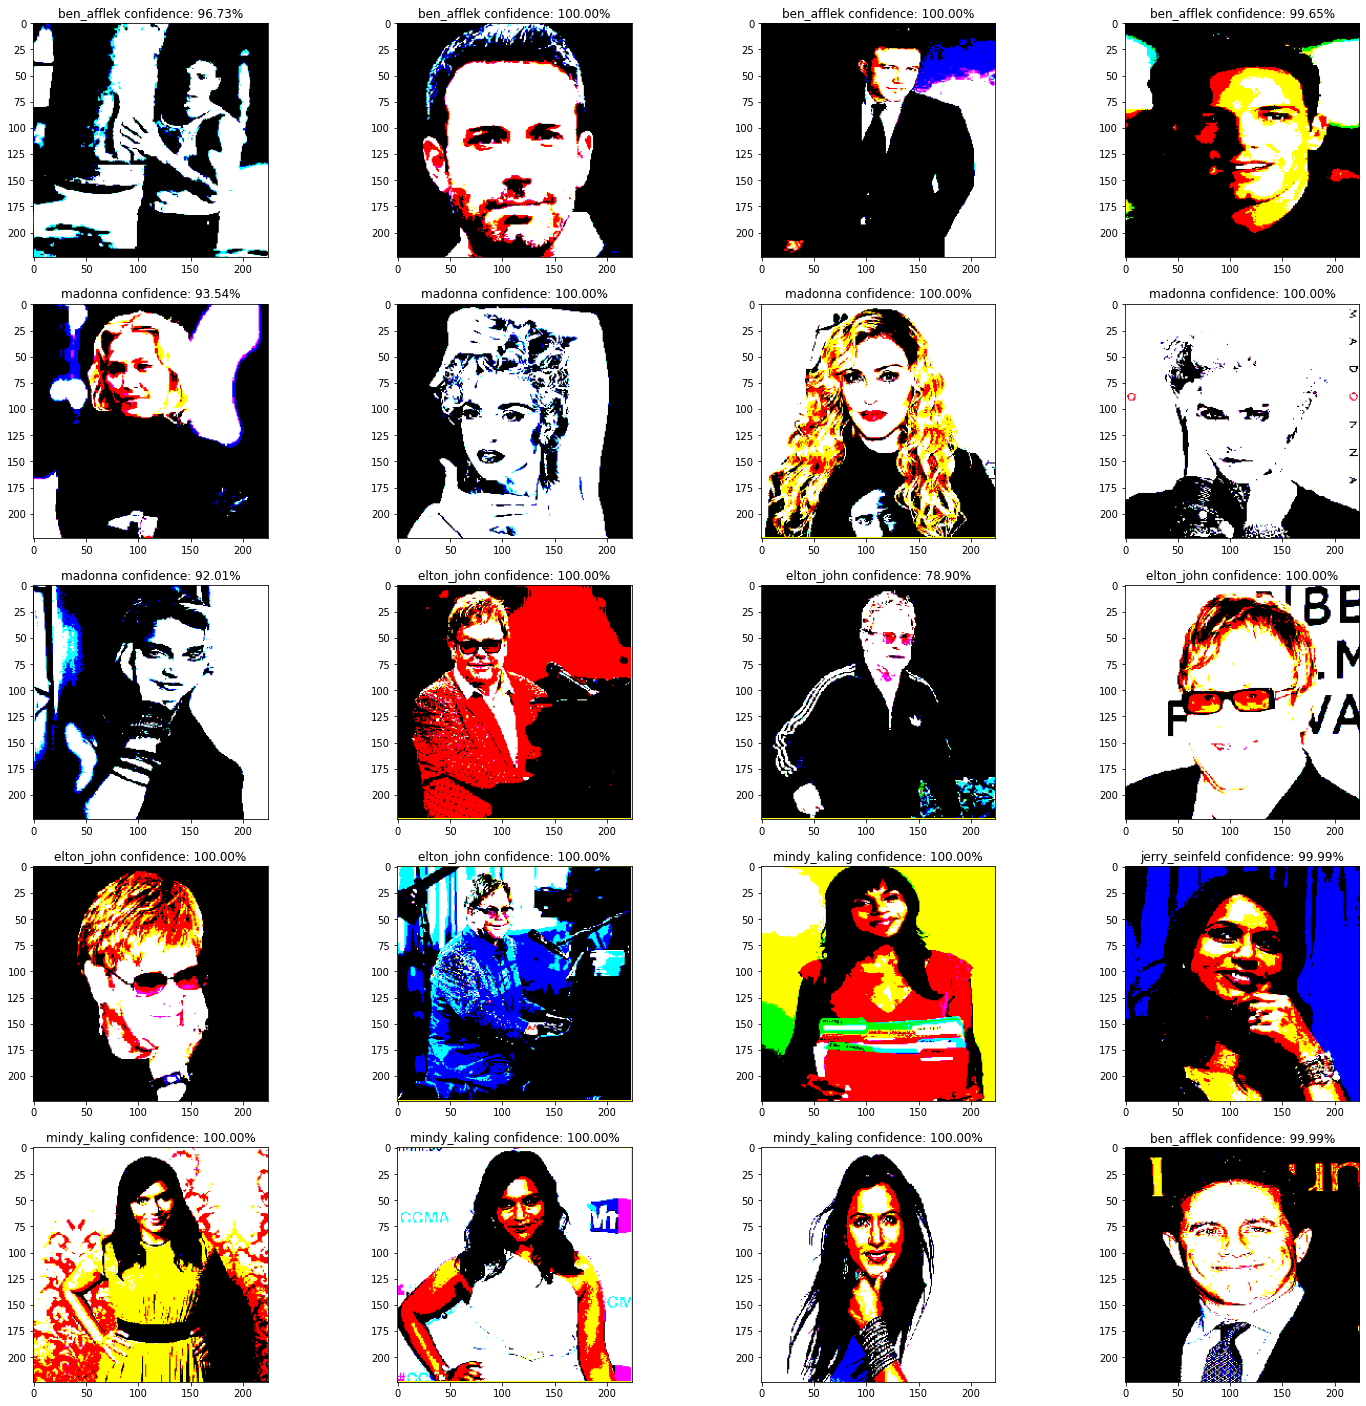

In [24]:
# Use openCV to detect face and label celebrity

columns = 4
rows = 5

fig = plt.figure(figsize = (25, 25))
for i in range(1, columns * rows + 1):
    pred = np.argmax(val_pred[i])
    confidance =  val_pred[i][pred] * 100
    person = classes[pred]
    message = "{} confidence: {:.2f}%".format(person, float(confidance))
    fig.add_subplot(rows, columns, i).set_title(message)
    plt.imshow(val_data[i], cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 93 114  32  32]]


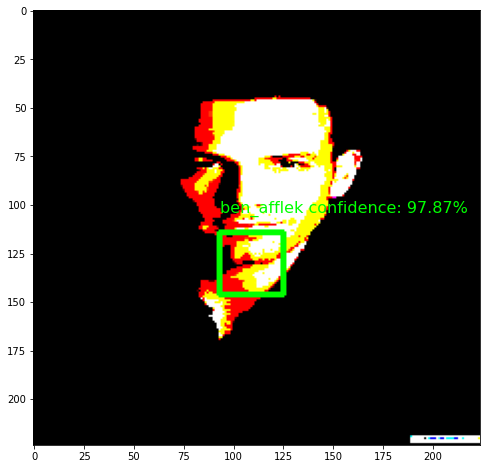

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[134 104  59  59]]


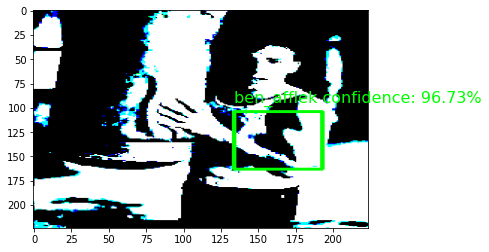

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


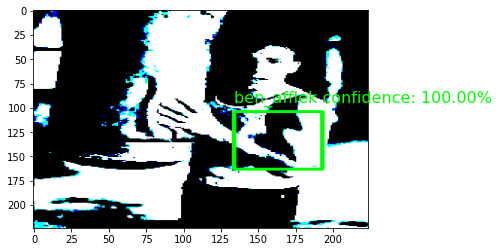

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


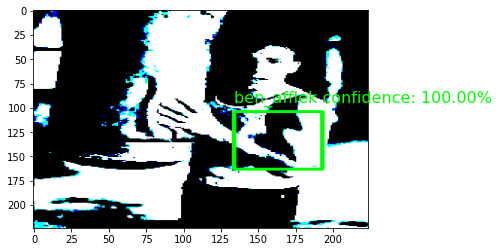

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 74 127  36  36]
 [ 34  57  86  86]]


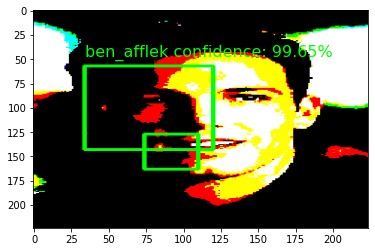

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


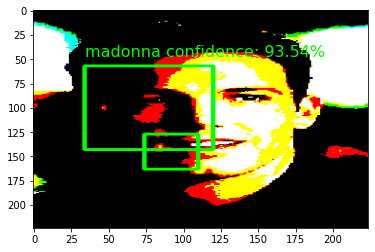

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[83  7 61 61]]


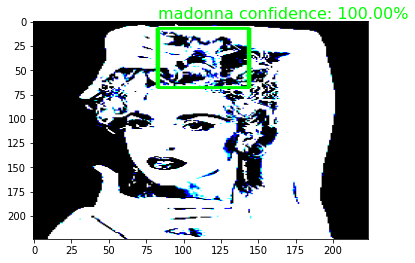

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[81 90 62 62]]


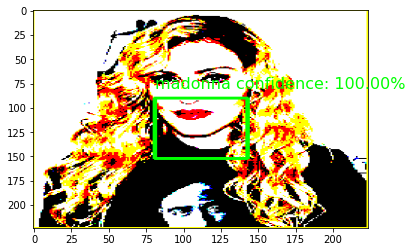

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[115  15  50  50]
 [ 54  93  58  58]]


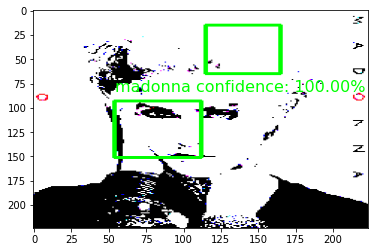

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[99 78 62 62]]


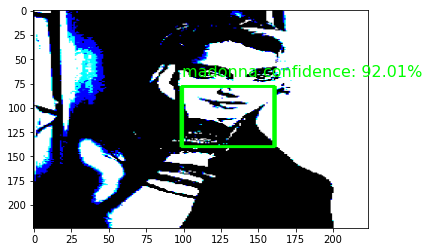

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 95  44 107 107]]


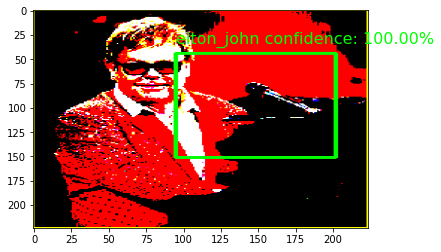

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[108  28  50  50]
 [ 92  99  83  83]]


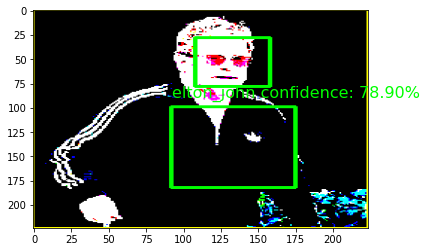

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


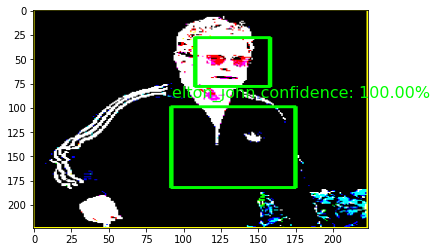

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


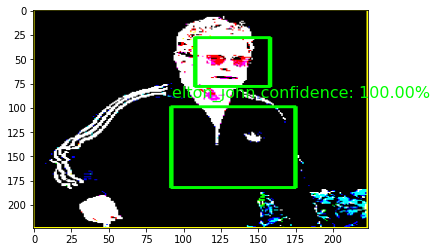

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[  5  42  31  31]
 [ 44 162  27  27]]


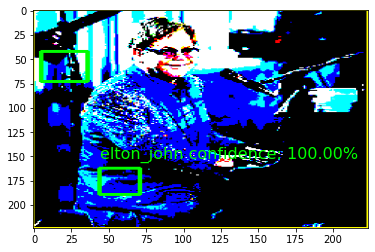

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[50 19 70 70]]


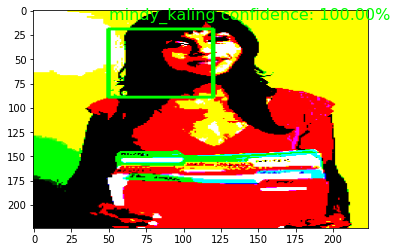

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


()


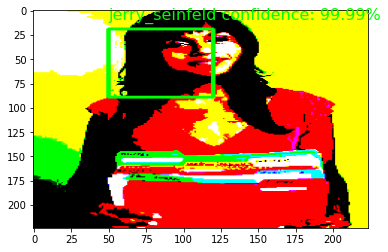

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 41   0 152 152]
 [ 37 125  45  45]]


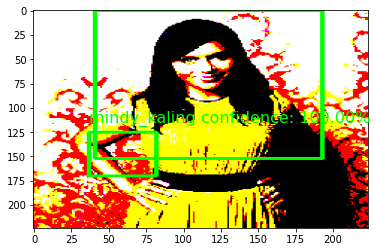

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[91 39 59 59]]


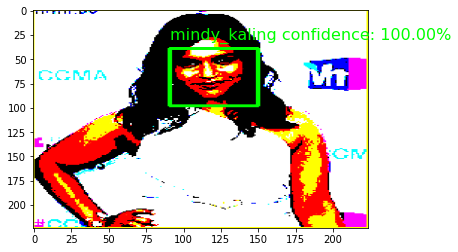

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[47 84 56 56]
 [72 54 77 77]]


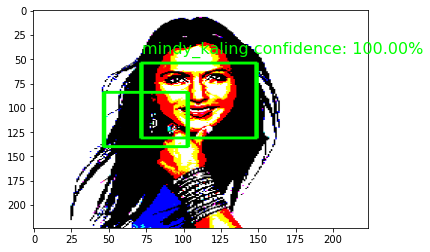

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[108  65  27  27]
 [ 55  91  49  49]]


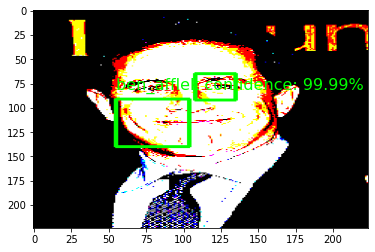

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[134 112  26  26]]


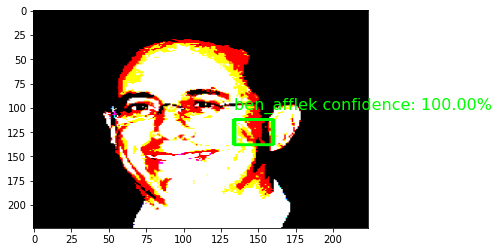

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[  9 105  49  49]]


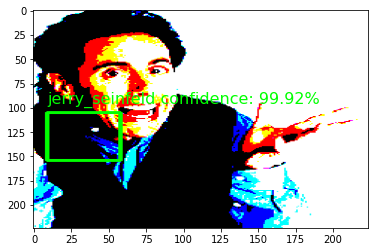

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[90 74 50 50]
 [81  3 60 60]]


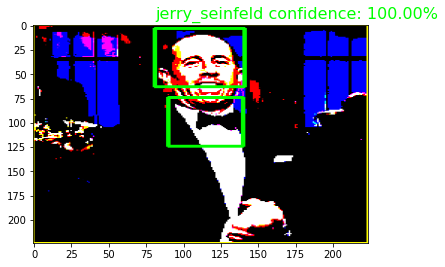

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 31  55 127 127]]


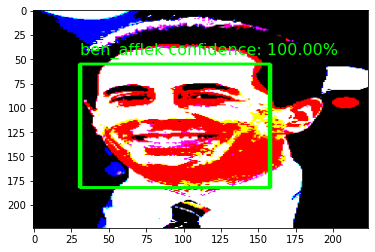

In [25]:
# Use openCV to detect face and label celebrity

# Create the haar cascade
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

columns = 4
rows = 5

fig = plt.figure(figsize = (8, 8))
for i in range(len(val_pred)):
    pred = np.argmax(val_pred[i])
    confidance =  val_pred[i][pred] * 100
    person = classes[pred]
    message = "{} confidence: {:.2f}%".format(person, float(confidance))
    
    # set image to gray scale
    gray = cv2.cvtColor(np.array(val_data[i], dtype = 'uint8'), cv2.COLOR_RGB2GRAY)
    
    # Detect faces in the image
    faces = faceCascade.detectMultiScale(gray,
        scaleFactor = 1.007,
        minNeighbors = 5,
        flags = cv2.CASCADE_SCALE_IMAGE)
    
    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        img2 = cv2.rectangle(val_data[i], (x, y), (x + w, y + h), (0, 255, 0), 2)
        text_x = x 
        text_y = y - 10
        
    plt.text(text_x, text_y, message, color = (0, 1, 0), size = 16)
    plt.imshow(img2, aspect = 'auto')
    plt.show()

Some additional work needs to be performed to in detection and labeling with the cv2 package. There are some faces that are not properly identified and some images appear more than once.